In [96]:
import numpy as np
from array import array
from os import stat
import matplotlib.pyplot as plt
import socket
import scipy.signal as signal

# Offline berechnung

# Signalaufbereitung
Im ersten Schritt muss die gespeicherte Sequenz geladen werden.
Zudem wird der DC Offset entfernt und das ganze Signal auf +-1 Normiert.

In [97]:
 # read in I/Q samples from binary file
filename = r"C:\Users\yanni\OneDrive\Documents\Hochschule\5.Semester\PAIND\Signale\loraShortShort.sig"
n_float32 = int(stat(filename).st_size/4)
with open(filename,"rb") as binary_file:
    arr = array('f')
    arr.fromfile(binary_file,n_float32)
rx = np.array(arr.tolist()[::2])+1j*np.array(arr.tolist()[1::2])
rx /= np.amax(np.abs(rx)) # normalize to 1
rx -= np.mean(rx)    # remove DC
print("signal size:",rx.shape[0])

signal size: 11090432


# Dastellung im Frequenzbereich
Um die Signale im Frequenzberich abbilden zu können, wird ein Spectrogramm benötigt, welche falblich die Signalsstärke anzeigt, sowie auf de nAchsen das Freqeunsspektrum und die Anzahl der Abtastungen

In [98]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def analysis_DFTFB(x,w,fftlen,ts):
    # analysis FB
    # x      : input signal
    # w      : window
    # fftlen : FFT size, not exceeding the window length
    # ts     : downsampling factor, not exceeding the window length

    x_shape = x.shape
    y = np.reshape(x,(int(np.prod(x_shape[0:-1])),x_shape[-1]))
    n_symbols = int(np.ceil(x_shape[-1]/ts))
    z = np.zeros((int(np.prod(x_shape[0:-1])),n_symbols,fftlen),dtype=np.complex64)
    for i in range(y.shape[0]):
        yi = np.concatenate((y[i,:],np.zeros((ts-(x_shape[-1]%ts))%ts)))
        yi = yi.reshape((n_symbols,ts))
        wi = np.zeros((n_symbols,len(w)),dtype=np.complex64)
        for j in range(0,int(np.ceil(len(w)/ts))):
            i1 = np.minimum((j+1)*ts,len(w))
            wi[0:n_symbols-j,j*ts:i1] = np.tile(w[j*ts:i1],(n_symbols-j,1))*yi[j:,0:i1-j*ts]
        for j in range(1,int(np.ceil(len(w)/fftlen))):
            i1 = np.minimum((j+1)*fftlen,len(w))
            wi[:,0:i1-j*fftlen] = wi[:,0:i1-j*fftlen]+wi[:,j*fftlen:i1]
        z[i,:,:] = np.fft.fft(wi[:,0:fftlen])
    return z.reshape((x_shape[0:-1]+(n_symbols,fftlen)))

def display_spectrogram(x):
    fftlen = 128
    ts = 2
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    # display spectrum
    levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
    cmap = plt.get_cmap('PiYG')
    norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
    xp,yp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
    fig = plt.figure()
    im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
    fig.colorbar(im,ax=fig.gca())
    fig.gca().set_title('spectrogram')
    plt.show()

def display_spectrogram_if_signal(x,signal_strength):
    # fftlen = 1024
    # ts = 8
    fftlen = 128
    ts = 2
    w = np.sqrt(1/1536)*(1+np.cos(np.arange(-np.pi,np.pi,2*np.pi/fftlen)))/2

    z = 20*np.log10(np.abs(np.fft.fftshift(analysis_DFTFB(x,w,fftlen,ts),axes=1)))+1000
#       [Bug]: Colorbar does not work for negative values with contour/contourf #21882
    if(z.max() >= signal_strength):
        # display spectrum
        levels = MaxNLocator(nbins=15).tick_values(z.min(),z.max())
        cmap = plt.get_cmap('PiYG')
        norm = BoundaryNorm(levels,ncolors=cmap.N,clip=True)
        xp,yp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]               # yp,xp = np.mgrid[slice(0,z.shape[0]),slice(0,z.shape[1])]
        fig = plt.figure()
        im = fig.gca().pcolormesh(xp,yp,z,cmap=cmap,norm=norm)
        fig.colorbar(im,ax=fig.gca())
        fig.gca().set_title('spectrogram')
        plt.show()

# Downsamling
Um eine Spektrumreduktion von insgesammt 1.625MHz auf 125kHz zu ermglichen wird das Signal mit einerm Faktor von 13 reduziert.
In das praxis bedeutet dies, dass nur jedes 13. Sample weiterverwendet wird. Es handeld sich somit um ein Downsampling mit dem Faktor 13.
Somit werden alle 8 möglichen Frequenzbänder auf ein Frequenzband reduziert.

# Signaldetection
Um zu überprüfen, dass das Signal auch auf der Datei befindet, wird eine simple detection von starken Signalen verwedet.
Dies dient jedoch nur zum visuellen Darstellen des Signals

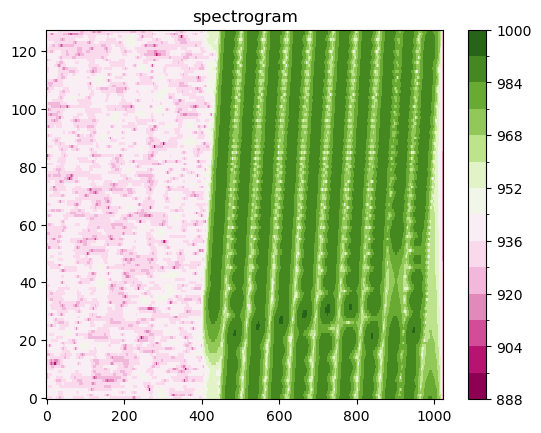

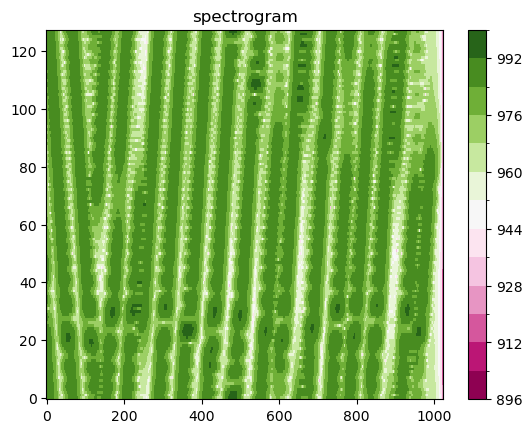

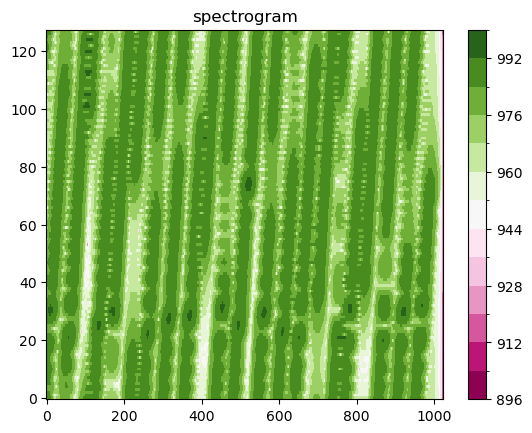

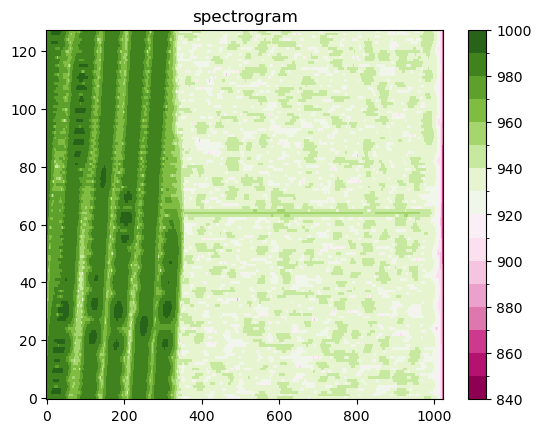

In [99]:
# Downsampling -> Überlagerung aller möglicher Frequenzbänder
rxd = rx
# rxd = signal.decimate(rx,10)
# rxd = signal.resample(rx,round(len(rx)/10),domain="freq")
# rxd = signal.resample_poly(rx,1,13)
#rxd = rx[::13]
# rxd = rxd[round(1.75*2**14):]


# SIZE = 2**15
# while (len(rxd)>(SIZE)):
#     display_spectrogram_if_signal(rxd[:(SIZE)],1005)
#     rxd = rxd[(SIZE):]

rxd = rx[::13]
SIZE = 2**11
while (len(rxd)>(SIZE)):
    display_spectrogram_if_signal(rxd[:(SIZE)],980)
    rxd = rxd[(SIZE):]


